In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import glob
import os
from utils import read_fmi_meteo_obs

In [2]:
out_fp = f'/Users/jpnousu/WBT_data/pallas_16/flowacc_1d.csv'
flowacc = pd.read_csv(out_fp, index_col=0)
flowacc = flowacc * 1e-6

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_87007/1669253943.py:10: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  q = pd.read_csv(file, skiprows=5, sep=';', parse_dates=[['date', ' time_UTC']], index_col=0)
/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_87007/1669253943.py:10: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  q = pd.read_csv(file, skiprows=5, sep=';', parse_dates=[['date', ' time_UTC']], index_col=0)
/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_87007/1669253943.py:10: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  q = pd.read_csv(file, skiprows=5, sep=';', parse_dates=[['date', ' tim

<Axes: xlabel='time'>

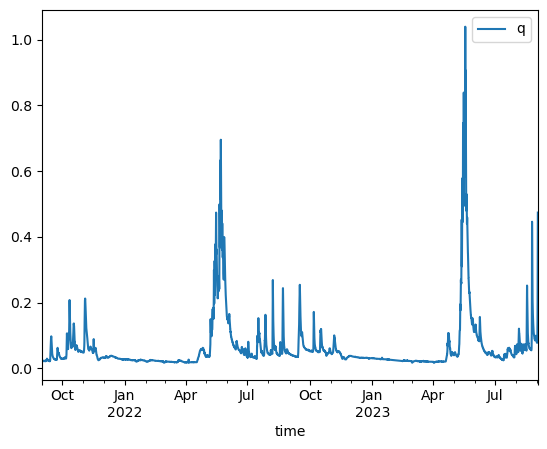

In [3]:
# Path to the directory containing the files
data_dir = r'/Users/jpnousu/DTS_data/AUX_DATA/'

# Find all relevant files (assuming they all start with 'Pallas_V-weir_hourly_')
files = sorted(glob.glob(os.path.join(data_dir, 'Pallas_V-weir_hourly_*.txt')))

# Read and combine all files
dfs = []
for file in files:
    q = pd.read_csv(file, skiprows=5, sep=';', parse_dates=[['date', ' time_UTC']], index_col=0)
    q = q.rename_axis('time')
    q.columns = q.columns.str.strip()  # Strip spaces from column names
    q = q.rename(columns={'Discharge': 'q'})
    q['q'] = q['q'].astype(float)
    dfs.append(q)

# Combine into a single DataFrame
q_all = pd.concat(dfs)
#q_all = q_all.resample('D').mean()
q_all.loc[slice('2021-09-01', '2023-09-01')].plot()

In [4]:
file = r'/Users/jpnousu/DTS_data/PROCESSED_DATA/pallas_dts_data_f_6.nc'
data = xr.open_dataset(file)

/Users/jpnousu/miniconda3/envs/wbt/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_87007/4212199430.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.95])


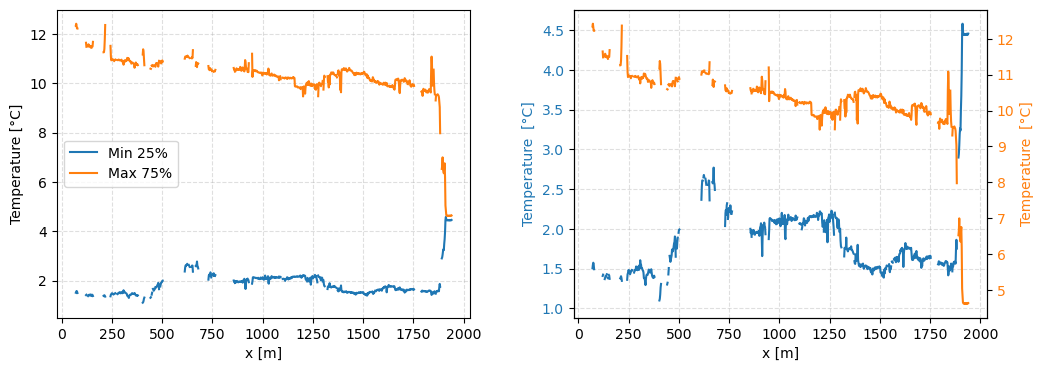

In [5]:
min_mode = 'quantile'  # or 'quantile'

# --- Step 1: Select only nocturnal times (22:00–06:00) ---
night_hours = data['time'].dt.hour
data_night = data.sel(time=((night_hours >= 22) | (night_hours < 6)))

# --- Step 2: Compute min and max data ---
if min_mode == 'quantile':
    min_data = data_night['T'].quantile(0.25, dim='time')
    max_data = data_night['T'].quantile(0.75, dim='time')

elif min_mode == 'flow':
    night_time_index = pd.to_datetime(data_night['time'].values)
    low_flow_night = low_flow.intersection(night_time_index)
    high_flow_night = high_flow.intersection(night_time_index)

    min_data = data_night['T'].sel(time=low_flow_night).mean(dim='time')
    max_data = data_night['T'].sel(time=high_flow_night).mean(dim='time')

# --- Step 3: Create figure with two subplots side-by-side ---
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 4),
    gridspec_kw={'wspace': 0.25}, sharex=False
)

# --- Left: Shared y-axis plot ---
min_data.plot(ax=ax1, color='tab:blue', label='Min 25%')
max_data.plot(ax=ax1, color='tab:orange', label='Max 75%')
ax1.set_title('')
ax1.set_ylabel('Temperature [°C]')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.4)

# --- Right: Dual y-axis plot ---
min_data.plot(ax=ax2, color='tab:blue', label='Min 25%)')
ax2.set_ylabel('Temperature  [°C]', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax3 = ax2.twinx()
max_data.plot(ax=ax3, color='tab:orange', label='Max 75%)')
ax3.set_ylabel('Temperature  [°C]', color='tab:orange')
ax3.tick_params(axis='y', labelcolor='tab:orange')

ax3.set_title('')
ax2.set_title('')
ax2.grid(True, linestyle='--', alpha=0.4)

# --- Layout and show ---
fig.tight_layout(rect=[0, 0, 1, 0.95])
filename = r'/Users/jpnousu/DTS_data/FIGS/sw_gw_sketch_new.png'
plt.savefig(filename, dpi=300)

/Users/jpnousu/miniconda3/envs/wbt/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


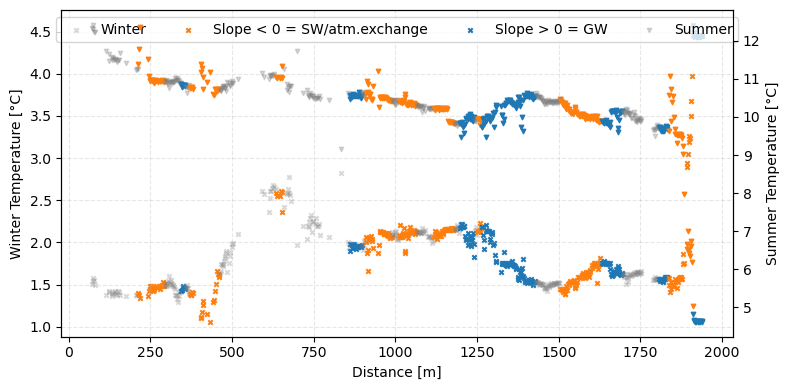

In [6]:
# Here plotting above right plot but classifying 
# sw and gw impacted areas based on their slope!

# --- Step 1: Select only nocturnal times (22:00–06:00) ---
night_hours = data['time'].dt.hour
data_night = data.sel(time=((night_hours >= 22) | (night_hours < 6)))

# --- Step 2: Compute min and max data ---
min_mode = 'quantile'  # or 'flow'

if min_mode == 'quantile':
    min_data = data_night['T'].quantile(0.25, dim='time')
    max_data = data_night['T'].quantile(0.75, dim='time')

elif min_mode == 'flow':
    night_time_index = pd.to_datetime(data_night['time'].values)
    low_flow_night = low_flow.intersection(night_time_index)
    high_flow_night = high_flow.intersection(night_time_index)

    min_data = data_night['T'].sel(time=low_flow_night).mean(dim='time')
    max_data = data_night['T'].sel(time=high_flow_night).mean(dim='time')

min_data = min_data.dropna(dim='x')
max_data = max_data.dropna(dim='x')

window = 40  # points in the rolling window
min_roll_windows = min_data.rolling(x=window, center=True).construct('window')
max_roll_windows = max_data.rolling(x=window, center=True).construct('window')

# Distance values for window
x_windows = min_data['x'].rolling(x=window, center=True).construct('window')
x_centered = x_windows - min_data['x'].values[:, None]

# Compute slope: slope = cov(x,y)/var(x)
min_deriv = ((x_centered * min_roll_windows).mean('window') -
             x_centered.mean('window') * min_roll_windows.mean('window')) / \
            ((x_centered**2).mean('window') - (x_centered.mean('window'))**2)

max_deriv = ((x_centered * max_roll_windows).mean('window') -
             x_centered.mean('window') * max_roll_windows.mean('window')) / \
            ((x_centered**2).mean('window') - (x_centered.mean('window'))**2)

# Classify derivatives: 1 = increasing, -1 = decreasing
min_class = xr.where(min_deriv > 0, 1, -1)
max_class = xr.where(max_deriv > 0, 1, -1)

gw_class = xr.where((min_class == -1) & (max_class == 1), 1, np.nan)
sw_class = xr.where((min_class == 1) & (max_class == -1), 1, np.nan)

temp_mask = (min_data > 4) & (min_data < 5) & (max_data > 4) & (max_data < 5)
gw_class = xr.where(temp_mask, 1, gw_class)

# Convert DataArrays to numpy
x_vals = min_data['x'].values
min_vals = min_data.values
max_vals = max_data.values
gw_mask = gw_class.fillna(0).values
sw_mask = sw_class.fillna(0).values

def plot_colored_markers(ax, x, y, gw_mask, sw_mask, marker='o', label_prefix=''):
    for i in range(len(x)):
        if gw_mask[i] == 1:
            ax.scatter(x[i], y[i], color='tab:blue', marker=marker, s=10, label=r'Slope > 0 = GW')
        elif sw_mask[i] == 1:
            ax.scatter(x[i], y[i], color='tab:orange', marker=marker, s=10, label=r'Slope < 0 = SW/atm.exchange')
        else:
            ax.scatter(x[i], y[i], color='grey', marker=marker, alpha=0.3, s=10, label=f'{label_prefix}' if i==0 else "")

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

# Min_data as points
plot_colored_markers(ax1, x_vals, min_vals, gw_mask, sw_mask, marker='x', label_prefix='Winter')

# Max_data as stars
plot_colored_markers(ax2, x_vals, max_vals, gw_mask, sw_mask, marker='v', label_prefix='Summer')

ax1.set_ylabel('Winter Temperature [°C]')
ax2.set_ylabel('Summer Temperature [°C]')
ax1.set_xlabel('Distance [m]')

ax1.grid(True, linestyle='--', alpha=0.3)

# Combine legends manually to avoid duplicates
lines_labels = {}
for ax in [ax1, ax2]:
    handles, labels = ax.get_legend_handles_labels()
    for h, l in zip(handles, labels):
        if l not in lines_labels:
            lines_labels[l] = h
ax1.legend(lines_labels.values(), lines_labels.keys(),loc='upper center', ncol=4)

#plt.title('Min (points) / Max (stars) Temperature Colored by GW/SW Classes')
plt.tight_layout()
filename = r'/Users/jpnousu/DTS_data/FIGS/sw_gw_classified.png'
plt.savefig(filename, dpi=300)

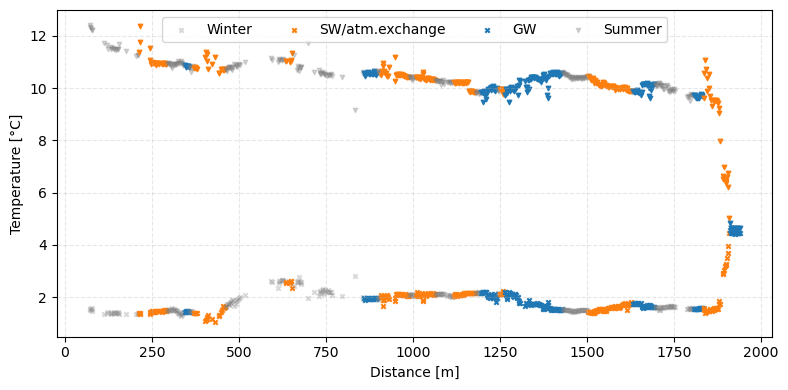

In [9]:
# --- Plot on ONE shared y-axis ---
fig, ax = plt.subplots(figsize=(8, 4))

# Plot winter (min_data)
plot_colored_markers(ax, x_vals, min_vals, gw_mask, sw_mask,
                     marker='x', label_prefix='Winter')

# Plot summer (max_data)
plot_colored_markers(ax, x_vals, max_vals, gw_mask, sw_mask,
                     marker='v', label_prefix='Summer')

ax.set_ylabel('Temperature [°C]')   # Shared y-axis
ax.set_xlabel('Distance [m]')
ax.grid(True, linestyle='--', alpha=0.3)

# Combine legends manually to avoid duplicates
lines_labels = {}
handles, labels = ax.get_legend_handles_labels()
for h, l in zip(handles, labels):
    if l not in lines_labels:
        lines_labels[l] = h

ax.legend(lines_labels.values(), lines_labels.keys(),
          loc='upper center', ncol=4)

plt.tight_layout()

filename = r'/Users/jpnousu/DTS_data/FIGS/sw_gw_classified_2.png'
plt.savefig(filename, dpi=300)

/Users/jpnousu/miniconda3/envs/wbt/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


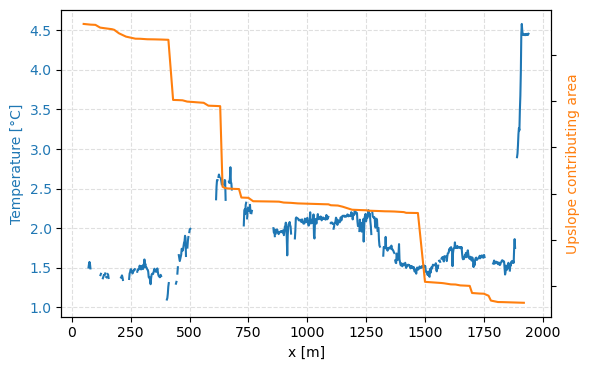

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

min_mode = 'quantile'  # or 'quantile'

# --- Step 1: Select only nocturnal times (22:00–06:00) ---
night_hours = data['time'].dt.hour
data_night = data.sel(time=((night_hours >= 22) | (night_hours < 6)))

# --- Step 2: Compute based on method ---
if min_mode == 'quantile':
    min_data = data_night['T'].quantile(0.25, dim='time')
    max_data = data_night['T'].quantile(0.75, dim='time')

elif min_mode == 'flow':
    # Restrict flow periods to overlap with data_night
    night_time_index = pd.to_datetime(data_night['time'].values)
    low_flow_night = low_flow.intersection(night_time_index)
    high_flow_night = high_flow.intersection(night_time_index)
    
    # Compute mean during low and high flow at night
    min_data = data_night['T'].sel(time=low_flow_night).mean(dim='time')
    max_data = data_night['T'].sel(time=high_flow_night).mean(dim='time')

# --- Step 3: Plot with dual y-axes ---
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot min data (left y-axis)
min_data.plot(ax=ax1, color='tab:blue', label='Min (low flow / 25th %)')
ax1.set_ylabel('Temperature [°C]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
flowacc.plot(ax=ax2, color='tab:orange')
ax2.set_ylabel('Upslope contributing area', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_yticklabels([])
ax2.get_legend().remove()  # safe only if a legend exists

ax1.set_title('')
ax2.set_title('')
ax1.grid(True, linestyle='--', alpha=0.4)

fig.tight_layout(rect=[0, 0, 1, 0.95])

filename = r'/Users/jpnousu/DTS_data/FIGS/sw_gw_floacc_sketch_new.png'
plt.savefig(filename, dpi=300)